This is to run tests on the 6-layer Neural Network on the updated feature list.

/Users/laurelmurphy/projects/diabetes-risk-predictor/diabetes-venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Params:
 learning_rate        0.01
dropout_rate          0.0
neurons                16
activation           relu
batch_size             16
val_accuracy     0.678748
Name: 4, dtype: object
Epoch 1/30


/Users/laurelmurphy/projects/diabetes-risk-predictor/diabetes-venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3182/3182 ━━━━━━━━━━━━━━━━━━━━ 2s 517us/step - accuracy: 0.6634 - loss: 0.6149 - val_accuracy: 0.6704 - val_loss: 0.6096
Epoch 2/30
3182/3182 ━━━━━━━━━━━━━━━━━━━━ 2s 487us/step - accuracy: 0.6664 - loss: 0.6102 - val_accuracy: 0.6764 - val_loss: 0.5991
Epoch 3/30
3182/3182 ━━━━━━━━━━━━━━━━━━━━ 2s 486us/step - accuracy: 0.6704 - loss: 0.6093 - val_accuracy: 0.6747 - val_loss: 0.5992
Epoch 4/30
3182/3182 ━━━━━━━━━━━━━━━━━━━━ 2s 480us/step - accuracy: 0.6665 - loss: 0.6096 - val_accuracy: 0.6759 - val_loss: 0.6034
Epoch 5/30
3182/3182 ━━━━━━━━━━━━━━━━━━━━ 2s 492us/step - accuracy: 0.6679 - loss: 0.6088 - val_accuracy: 0.6752 - val_loss: 0.6024
Epoch 6/30
3182/3182 ━━━━━━━━━━━━━━━━━━━━ 2s 484us/step - accuracy: 0.6645 - loss: 0.6089 - val_accuracy: 0.6754 - val_loss: 0.6015
Epoch 7/30
3182/3182 ━━━━━━━━━━━━━━━━━━━━ 2s 483us/step - accuracy: 0.6641 - loss: 0.6091 - val_accuracy: 0.6733 - val_loss: 0.6037
Epoch 8/30
3182/3182 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - accuracy: 0.6656 - loss: 0.60

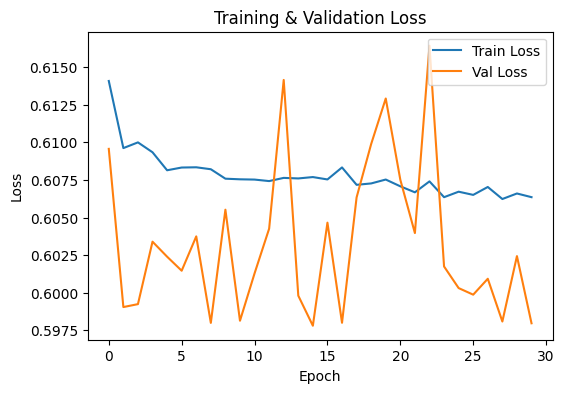

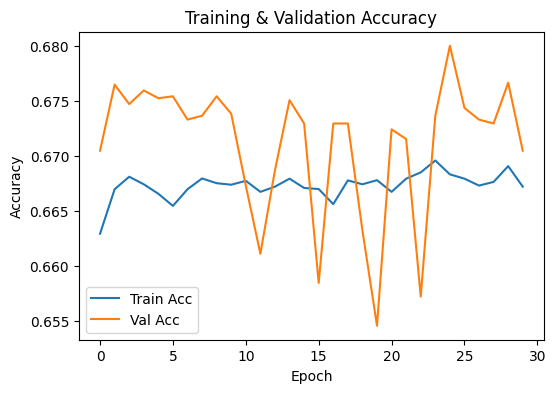

442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step


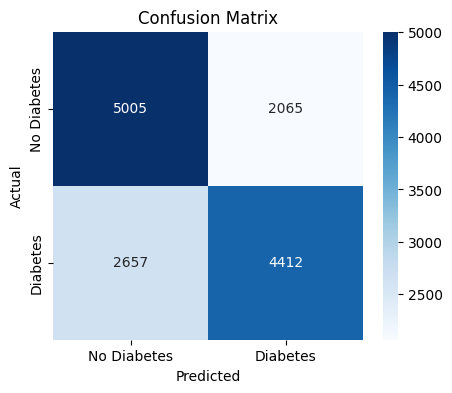

Classification Report:
              precision    recall  f1-score   support

           0     0.6532    0.7079    0.6795      7070
           1     0.6812    0.6241    0.6514      7069

    accuracy                         0.6660     14139
   macro avg     0.6672    0.6660    0.6654     14139
weighted avg     0.6672    0.6660    0.6654     14139



In [3]:
# Cell 1 – Imports & Data Loading
import pandas as pd
import numpy as np
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load the feature-selected dataset
df = pd.read_csv('3_to_classes_.csv')
X = df[['DiffWalk','Sex','Age','Education','Income']].values
y = df['Diabetes_binary'].values

# Cell 2 – Preprocessing: train/test split & scaling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

# Cell 3 – Build model function
def build_model(learning_rate, dropout_rate, neurons, activation):
    model = Sequential()
    for _ in range(6):
        model.add(Dense(neurons, activation=activation, input_shape=(X_train.shape[1],)))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Cell 4 – Manual Grid Search
grid_params = {
    'learning_rate': [1e-2, 1e-3, 1e-4],
    'dropout_rate': [0.0, 0.2],
    'neurons': [8, 16, 32],
    'activation': ['relu', 'tanh'],
    'batch_size': [16, 32]
}

results = []
for lr, dr, n, act, bs in product(
    grid_params['learning_rate'],
    grid_params['dropout_rate'],
    grid_params['neurons'],
    grid_params['activation'],
    grid_params['batch_size']
):
    tf.keras.backend.clear_session()
    model = build_model(lr, dr, n, act)
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=bs,
        validation_split=0.1,
        verbose=0
    )
    val_acc = history.history['val_accuracy'][-1]
    results.append({
        'learning_rate': lr,
        'dropout_rate': dr,
        'neurons': n,
        'activation': act,
        'batch_size': bs,
        'val_accuracy': val_acc
    })

results_df = pd.DataFrame(results)
best = results_df.loc[results_df['val_accuracy'].idxmax()]
print("Best Params:\n", best)

# Cell 5 – Train Best Model & Plot Curves
best_model = build_model(
    learning_rate=best['learning_rate'],
    dropout_rate=best['dropout_rate'],
    neurons=int(best['neurons']),
    activation=best['activation']
)
history = best_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=int(best['batch_size']),
    validation_split=0.1,
    verbose=1
)

# Plot Loss vs. Epoch
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy vs. Epoch
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Cell 6 – Confusion Matrix & Metrics
y_pred_prob = best_model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Diabetes','Diabetes'], 
            yticklabels=['No Diabetes','Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))


/Users/laurelmurphy/projects/diabetes-risk-predictor/diabetes-venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏆 Best Hyperparameters:
 {'learning_rate': 0.01, 'dropout_rate': 0.0, 'neurons': 32, 'activation': 'relu', 'batch_size': 32, 'val_accuracy': 0.6771569848060608}
Epoch 1/30


/Users/laurelmurphy/projects/diabetes-risk-predictor/diabetes-venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1591/1591 ━━━━━━━━━━━━━━━━━━━━ 2s 596us/step - accuracy: 0.6521 - loss: 0.6242 - val_accuracy: 0.6643 - val_loss: 0.6020
Epoch 2/30
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 1s 529us/step - accuracy: 0.6647 - loss: 0.6122 - val_accuracy: 0.6653 - val_loss: 0.6020
Epoch 3/30
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 1s 535us/step - accuracy: 0.6632 - loss: 0.6106 - val_accuracy: 0.6798 - val_loss: 0.5995
Epoch 4/30
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 1s 535us/step - accuracy: 0.6660 - loss: 0.6099 - val_accuracy: 0.6745 - val_loss: 0.5986
Epoch 5/30
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 1s 538us/step - accuracy: 0.6611 - loss: 0.6093 - val_accuracy: 0.6727 - val_loss: 0.5983
Epoch 6/30
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 1s 530us/step - accuracy: 0.6664 - loss: 0.6083 - val_accuracy: 0.6726 - val_loss: 0.5984
Epoch 7/30
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 1s 528us/step - accuracy: 0.6651 - loss: 0.6082 - val_accuracy: 0.6757 - val_loss: 0.5993
Epoch 8/30
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 1s 558us/step - accuracy: 0.6647 - loss: 0.60

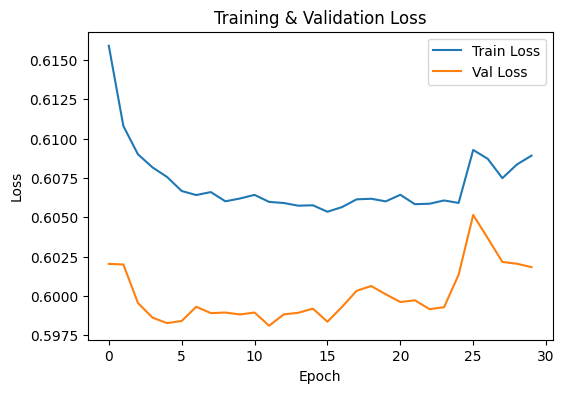

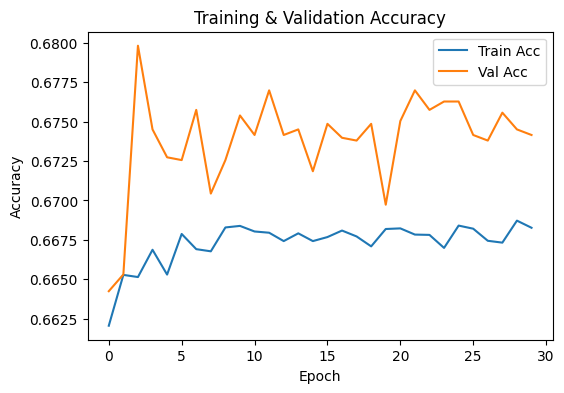

🔍 Test Loss: 0.6025 — Test Accuracy: 0.6727

442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step


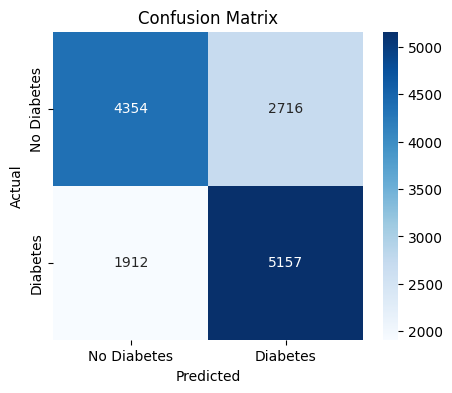

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.6949    0.6158    0.6530      7070
           1     0.6550    0.7295    0.6903      7069

    accuracy                         0.6727     14139
   macro avg     0.6749    0.6727    0.6716     14139
weighted avg     0.6749    0.6727    0.6716     14139



In [4]:
# Cell 1 – Imports, Seeds & Data Loading
import pandas as pd
import numpy as np
import tensorflow as tf
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Load the feature-selected dataset
df = pd.read_csv('3_to_classes_.csv')
X = df[['DiffWalk','Sex','Age','Education','Income']].values
y = df['Diabetes_binary'].values

# Cell 2 – Preprocessing: train/test split & scaling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

# Cell 3 – Build model function
def build_model(learning_rate, dropout_rate, neurons, activation):
    model = Sequential()
    for _ in range(6):
        model.add(Dense(neurons, activation=activation, input_shape=(X_train.shape[1],)))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Cell 4 – Manual Grid Search
grid_params = {
    'learning_rate': [1e-2, 1e-3, 1e-4],
    'dropout_rate': [0.0, 0.2],
    'neurons': [8, 16, 32],
    'activation': ['relu', 'tanh'],
    'batch_size': [16, 32]
}

results = []
for lr, dr, n, act, bs in product(
    grid_params['learning_rate'],
    grid_params['dropout_rate'],
    grid_params['neurons'],
    grid_params['activation'],
    grid_params['batch_size']
):
    tf.keras.backend.clear_session()
    model = build_model(lr, dr, n, act)
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=bs,
        validation_split=0.1,
        verbose=0
    )
    val_acc = history.history['val_accuracy'][-1]
    results.append({
        'learning_rate': lr,
        'dropout_rate': dr,
        'neurons': n,
        'activation': act,
        'batch_size': bs,
        'val_accuracy': val_acc
    })

results_df = pd.DataFrame(results)
best = results_df.loc[results_df['val_accuracy'].idxmax()]
print("🏆 Best Hyperparameters:\n", best.to_dict())

# Cell 5 – Retrain Best Model & Plot Curves
best_model = build_model(
    learning_rate=best['learning_rate'],
    dropout_rate=best['dropout_rate'],
    neurons=int(best['neurons']),
    activation=best['activation']
)
history = best_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=int(best['batch_size']),
    validation_split=0.1,
    verbose=1
)

# Plot Loss vs. Epoch
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],      label='Train Loss')
plt.plot(history.history['val_loss'],  label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.show()

# Plot Accuracy vs. Epoch
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'],      label='Train Acc')
plt.plot(history.history['val_accuracy'],  label='Val Acc')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.show()

# Cell 6 – Final Test Evaluation & Metrics
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"🔍 Test Loss: {test_loss:.4f} — Test Accuracy: {test_acc:.4f}\n")

# Confusion Matrix
y_pred_prob = best_model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes','Diabetes'],
            yticklabels=['No Diabetes','Diabetes'])
plt.title('Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.show()

# Classification Report
print("📊 Classification Report:")
print(classification_report(y_test, y_pred, digits=4))


/Users/laurelmurphy/projects/diabetes-risk-predictor/diabetes-venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏆 Best Hyperparameters:
 {'learning_rate': 0.0001, 'dropout_rate': 0.0, 'neurons': 16, 'activation': 'elu', 'batch_size': 16, 'val_accuracy': 0.6782178282737732}
Epoch 1/100


/Users/laurelmurphy/projects/diabetes-risk-predictor/diabetes-venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3182/3182 ━━━━━━━━━━━━━━━━━━━━ 4s 942us/step - accuracy: 0.5935 - loss: 0.6964 - val_accuracy: 0.6699 - val_loss: 0.6036 - learning_rate: 1.0000e-04
Epoch 2/100
3182/3182 ━━━━━━━━━━━━━━━━━━━━ 3s 813us/step - accuracy: 0.6533 - loss: 0.6227 - val_accuracy: 0.6711 - val_loss: 0.6014 - learning_rate: 1.0000e-04
Epoch 3/100
3182/3182 ━━━━━━━━━━━━━━━━━━━━ 3s 823us/step - accuracy: 0.6579 - loss: 0.6191 - val_accuracy: 0.6750 - val_loss: 0.6006 - learning_rate: 1.0000e-04
Epoch 4/100
3182/3182 ━━━━━━━━━━━━━━━━━━━━ 3s 831us/step - accuracy: 0.6598 - loss: 0.6175 - val_accuracy: 0.6745 - val_loss: 0.6002 - learning_rate: 1.0000e-04
Epoch 5/100
3182/3182 ━━━━━━━━━━━━━━━━━━━━ 3s 808us/step - accuracy: 0.6604 - loss: 0.6165 - val_accuracy: 0.6745 - val_loss: 0.5999 - learning_rate: 1.0000e-04
Epoch 6/100
3182/3182 ━━━━━━━━━━━━━━━━━━━━ 3s 810us/step - accuracy: 0.6604 - loss: 0.6157 - val_accuracy: 0.6724 - val_loss: 0.5997 - learning_rate: 1.0000e-04
Epoch 7/100
3182/3182 ━━━━━━━━━━━━━━━━━━━━ 3s 

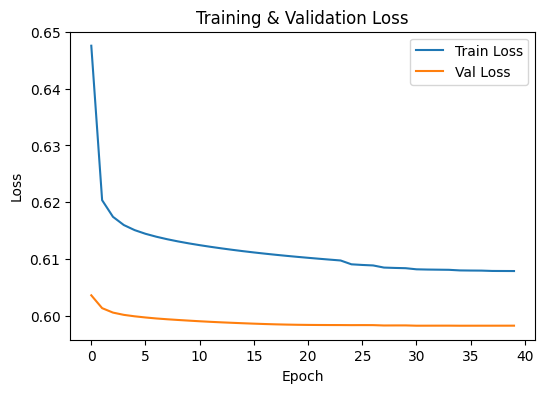

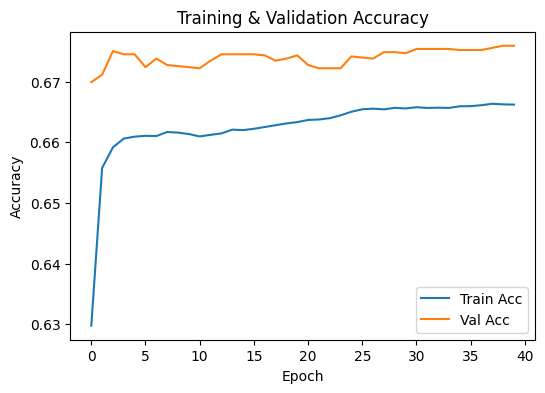

🔍 Test Loss: 0.5993 — Test Accuracy: 0.6734

442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step


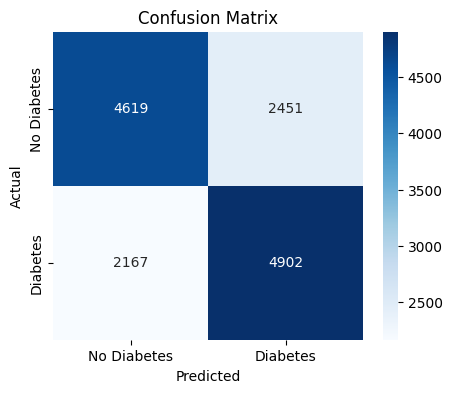

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.6807    0.6533    0.6667      7070
           1     0.6667    0.6935    0.6798      7069

    accuracy                         0.6734     14139
   macro avg     0.6737    0.6734    0.6733     14139
weighted avg     0.6737    0.6734    0.6733     14139



In [5]:
# Cell 1 – Imports, Seeds & Data Loading
import pandas as pd
import numpy as np
import tensorflow as tf
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Load the feature-selected dataset
df = pd.read_csv('3_to_classes_.csv')
X = df[['DiffWalk','Sex','Age','Education','Income']].values
y = df['Diabetes_binary'].values

# Cell 2 – Preprocessing: train/test split & scaling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

# Cell 3 – Build model function (with BatchNorm + flexible Activation)
def build_model(learning_rate, dropout_rate, neurons, activation):
    model = Sequential()
    for _ in range(6):
        model.add(Dense(neurons, input_shape=(X_train.shape[1],)))
        model.add(BatchNormalization())
        model.add(Activation(activation))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model

# Cell 4 – Manual Grid Search (20 epochs each)
grid_params = {
    'learning_rate': [1e-2, 1e-3, 1e-4],
    'dropout_rate': [0.0, 0.2, 0.5],
    'neurons': [8, 16, 32],
    'activation': ['relu', 'tanh', 'elu'],
    'batch_size': [16, 32]
}

results = []
for lr, dr, n, act, bs in product(
    grid_params['learning_rate'],
    grid_params['dropout_rate'],
    grid_params['neurons'],
    grid_params['activation'],
    grid_params['batch_size']
):
    tf.keras.backend.clear_session()
    model = build_model(lr, dr, n, act)
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=bs,
        validation_split=0.1,
        verbose=0
    )
    val_acc = history.history['val_accuracy'][-1]
    results.append({
        'learning_rate': lr,
        'dropout_rate': dr,
        'neurons': n,
        'activation': act,
        'batch_size': bs,
        'val_accuracy': val_acc
    })

results_df = pd.DataFrame(results)
best = results_df.loc[results_df['val_accuracy'].idxmax()]
print("🏆 Best Hyperparameters:\n", best.to_dict())

# Cell 5 – Retrain Best Model with Callbacks & Plot Curves
es    = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

best_model = build_model(
    learning_rate=best['learning_rate'],
    dropout_rate=best['dropout_rate'],
    neurons=int(best['neurons']),
    activation=best['activation']
)
history = best_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=int(best['batch_size']),
    validation_split=0.1,
    callbacks=[es, rlrop],
    verbose=1
)

# Plot Loss vs. Epoch
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],      label='Train Loss')
plt.plot(history.history['val_loss'],  label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.show()

# Plot Accuracy vs. Epoch
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'],      label='Train Acc')
plt.plot(history.history['val_accuracy'],  label='Val Acc')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.show()

# Cell 6 – Final Test Evaluation & Metrics
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"🔍 Test Loss: {test_loss:.4f} — Test Accuracy: {test_acc:.4f}\n")

# Confusion Matrix
y_pred_prob = best_model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes','Diabetes'],
            yticklabels=['No Diabetes','Diabetes'])
plt.title('Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.show()

# Classification Report
print("📊 Classification Report:")
print(classification_report(y_test, y_pred, digits=4))


/Users/laurelmurphy/projects/diabetes-risk-predictor/diabetes-venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏆 Best val_acc=0.9132 with lr=0.001, mom=0.0, neurons=32, l1=0.0001, l2=0.0


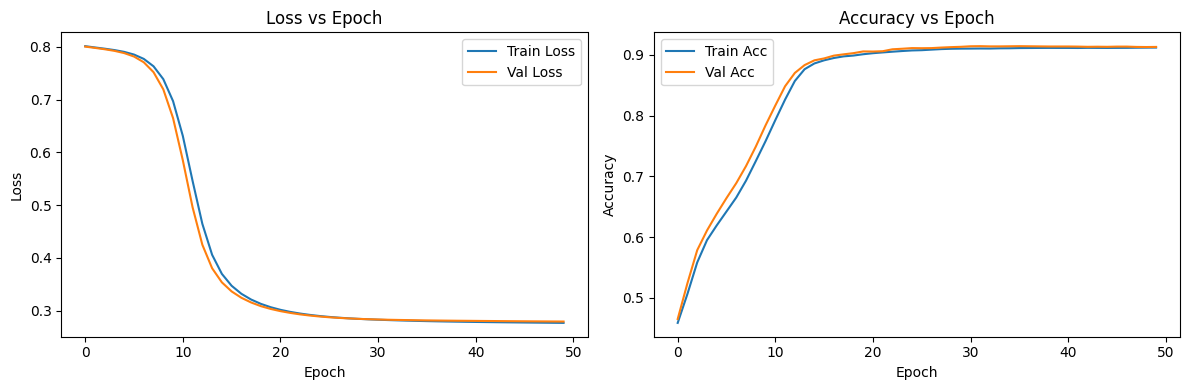


Test  Loss: 0.2812
Test  Acc : 0.9102
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step

Confusion Matrix:
 [[6401  669]
 [ 601 6468]]

Precision: 0.9063
Recall   : 0.9150
F1 Score : 0.9106


In [7]:
# --- IMPORTS (unchanged) ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

# --- LOAD & PREPARE DATA (unchanged) ---
df = pd.read_csv('3_to_classes_.csv')
y = df['Diabetes_binary'].astype(np.float32).values
X_raw = df.drop(columns='Diabetes_binary')
X_encoded = pd.get_dummies(X_raw.astype(str), prefix=X_raw.columns)
X = X_encoded.values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- GRID SEARCH HYPERPARAMETERS ---
param_grid = {
    'lr':       [0.01, 0.001],
    'momentum':[0.9, 0.0],
    'neurons': [16, 32],
    'l1':      [0.0, 1e-4],
    'l2':      [0.0, 1e-4]
}

best_score = 0
best_cfg   = None
best_hist  = None

for lr in param_grid['lr']:
  for mom in param_grid['momentum']:
    for n in param_grid['neurons']:
      for l1 in param_grid['l1']:
        for l2 in param_grid['l2']:
          # build 6-layer model
          model = Sequential()
          for i in range(6):
            if i==0:
              model.add(Dense(n,
                              input_dim=X_train.shape[1],
                              activation='relu',
                              kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))
            else:
              model.add(Dense(n,
                              activation='relu',
                              kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))
          model.add(Dense(1, activation='sigmoid'))

          # compile & train
          opt = SGD(learning_rate=lr, momentum=mom)
          model.compile(optimizer=opt,
                        loss='binary_crossentropy',
                        metrics=['accuracy'])
          hist = model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=64,
            validation_split=0.1,
            verbose=0
          )

          val_acc = hist.history['val_accuracy'][-1]
          if val_acc > best_score:
            best_score = val_acc
            best_cfg   = (lr, mom, n, l1, l2)
            best_model = model
            best_hist  = hist

print(f"🏆 Best val_acc={best_score:.4f} with lr={best_cfg[0]}, mom={best_cfg[1]}, "
      f"neurons={best_cfg[2]}, l1={best_cfg[3]}, l2={best_cfg[4]}")

# --- PLOT TRAINING / VALIDATION CURVES ---
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(best_hist.history['loss'], label='Train Loss')
plt.plot(best_hist.history['val_loss'], label='Val Loss')
plt.title('Loss vs Epoch'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(best_hist.history['accuracy'], label='Train Acc')
plt.plot(best_hist.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy vs Epoch'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.tight_layout()
plt.show()

# --- EVALUATE ON HELD-OUT TEST SET ---
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest  Loss: {test_loss:.4f}")
print(f"Test  Acc : {test_acc:.4f}")

# --- CONFUSION MATRIX & CLASSIFICATION METRICS ---
y_prob = best_model.predict(X_test).flatten()
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
print(f"\nPrecision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
